Project 4: Plant leave recognizer

In [ ]:
!pip install -q kaggle

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "angiierobbb"
os.environ['KAGGLE_KEY'] = "6f4f1770f4675f63b4ab350b57a6f49c"

In [ ]:
#import dataset from kaggle 
!kaggle datasets download -d csafrit2/plant-leaves-for-image-classification

100% 6.56G/6.56G [04:35<00:00, 19.6MB/s]
100% 6.56G/6.56G [04:35<00:00, 25.6MB/s]


In [ ]:
#unzip the dataset
!unzip -q /content/plant-leaves-for-image-classification.zip

In [ ]:
import shutil

In [ ]:
# delete diseased folders 
list_diseased = ["/content/Plants_2/test/Alstonia Scholaris diseased (P2a)","/content/Plants_2/test/Arjun diseased (P1a)","/content/Plants_2/test/Bael diseased (P4b)","/content/Plants_2/test/Chinar diseased (P11b)","/content/Plants_2/test/Gauva diseased (P3b)","/content/Plants_2/test/Jamun diseased (P5b)","/content/Plants_2/test/Jatropha diseased (P6b)","/content/Plants_2/test/Lemon diseased (P10b)","/content/Plants_2/test/Mango diseased (P0b)","/content/Plants_2/test/Pomegranate diseased (P9b)","/content/Plants_2/test/Pongamia Pinnata diseased (P7b)","/content/Plants_2/train/Alstonia Scholaris diseased (P2a)","/content/Plants_2/train/Arjun diseased (P1a)","/content/Plants_2/train/Bael diseased (P4b)","/content/Plants_2/train/Chinar diseased (P11b)","/content/Plants_2/train/Gauva diseased (P3b)","/content/Plants_2/train/Jamun diseased (P5b)","/content/Plants_2/train/Jatropha diseased (P6b)","/content/Plants_2/train/Lemon diseased (P10b)","/content/Plants_2/train/Mango diseased (P0b)","/content/Plants_2/train/Pomegranate diseased (P9b)","/content/Plants_2/train/Pongamia Pinnata diseased (P7b)","/content/Plants_2/valid/Alstonia Scholaris diseased (P2a)","/content/Plants_2/valid/Arjun diseased (P1a)","/content/Plants_2/valid/Bael diseased (P4b)","/content/Plants_2/valid/Chinar diseased (P11b)","/content/Plants_2/valid/Gauva diseased (P3b)","/content/Plants_2/valid/Jamun diseased (P5b)","/content/Plants_2/valid/Jatropha diseased (P6b)","/content/Plants_2/valid/Lemon diseased (P10b)","/content/Plants_2/valid/Mango diseased (P0b)","/content/Plants_2/valid/Pomegranate diseased (P9b)","/content/Plants_2/valid/Pongamia Pinnata diseased (P7b)"]

In [ ]:
for directory in list_diseased : 
  shutil.rmtree (directory)

In [ ]:
import tensorflow as tf 
from tensorflow import keras 
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
INPUT_SHAPE = (128,128) #inpute shape of images 
BATCH_SIZE = 32  #define batch size for training data 
SEED = 123
RESCALE  = 1.0/255 #rescale the pixel values of the images 

In [ ]:
#create Image Data Generator objects 
datagenA = ImageDataGenerator(
    rescale=RESCALE, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

datagenB = ImageDataGenerator(rescale=RESCALE)

In [ ]:
#flow from directory
train_generator = datagenA.flow_from_directory(
    directory=r"/content/Plants_2/train",
    target_size= INPUT_SHAPE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

Found 2163 images belonging to 11 classes.


In [ ]:
valid_generator = datagenA.flow_from_directory(
    directory=r"/content/Plants_2/valid",
    target_size=INPUT_SHAPE,
    color_mode="rgb",
    batch_size= BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

Found 55 images belonging to 11 classes.


In [ ]:
test_generator = datagenB.flow_from_directory(
    directory=r"/content/Plants_2/test",
    target_size= INPUT_SHAPE,
    color_mode="rgb",
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False,
    seed=SEED
)

Found 55 images belonging to 11 classes.


In [ ]:
#import necessary layers and models from Tenserflow Keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout 

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = 'weights_epoch_{epoch:02d}.h5' #specify file path pattern for saving weights 
#create a ModelCheckpoint callback to save weights during training 
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, verbose=1)

#Early Stop callback to stop trainin gearly based on validation loss if it does not imporve for 5 epochs, starting from epoch 10
earlystopping = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, 
                              restore_best_weights = False, start_from_epoch=10) 

In [ ]:
def make_model (params):
  #hyperparameters
  dropout_hyper = params.Float("dropout", min_value = 0.0, max_value = 0.3, step= 0.1)
  filters_hyper= params.Choice("filters", values =[32,64,128])
  dense_hyper = params.Choice("units", values = [32,64])
  #model construction
  model_leaves=Sequential()

  #Convolutionla layers
  model_leaves.add(Conv2D(filters= filters_hyper, kernel_size=(3,3),input_shape = (128,128,3)))
  model_leaves.add(Activation(activation="relu"))
  model_leaves.add(MaxPooling2D(pool_size=(2,2)))
  model_leaves.add(Dropout(dropout_hyper))

  model_leaves.add(Conv2D(filters=filters_hyper, kernel_size=(3,3)))
  model_leaves.add(Activation(activation="relu"))
  model_leaves.add(MaxPooling2D(pool_size=(2,2))) 
  model_leaves.add(Dropout(dropout_hyper))

  model_leaves.add(Conv2D(filters=filters_hyper, kernel_size=(3,3)))
  model_leaves.add(Activation(activation="relu"))
  model_leaves.add(MaxPooling2D(pool_size=(2,2))) 
  model_leaves.add(Dropout(dropout_hyper))

  #flatten and dense layer
  model_leaves.add(Flatten())
  model_leaves.add(Dense(dense_hyper)) 
  model_leaves.add(Activation("relu"))
  model_leaves.add(Dropout(dropout_hyper))

  #output layer
  model_leaves.add(Dense(11))
  model_leaves.add(Activation("softmax")) 

  #model.compile
  model_leaves.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics= ["accuracy"])
  return model_leaves #returning the constructed model


In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 11.3 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:
# create a Random Search tuner to search for the optimal hyperparamters 
tuner=kt.RandomSearch(make_model, objective="val_accuracy", max_trials=3, directory="grid_search")

#perform the hyperparameter search, training the model for 3 epochs
tuner.search(train_generator, validation_data = valid_generator, epochs=3)

Trial 3 Complete [00h 36m 46s]
val_accuracy: 0.6909090876579285

Best val_accuracy So Far: 0.6909090876579285
Total elapsed time: 01h 51m 54s


In [ ]:
#get the best hyperparameters from the tuner and extract them 
best_parameters= tuner.get_best_hyperparameters()[0]
best_parameters.get_config()["values"]

{'dropout': 0.1, 'filters': 128, 'units': 64}

In [ ]:
#build the model using the best hyperparameters found by the tuner 
model_leaves= tuner.hypermodel.build(best_parameters)

In [ ]:
#train the model 
mod_leaves = model_leaves.fit_generator(generator = train_generator,validation_data = valid_generator,epochs=5, callbacks=[checkpoint,earlystopping])

<ipython-input-39-a5520efb22bd>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  mod_leaves = model_leaves.fit_generator(generator = train_generator,validation_data = valid_generator,epochs=5, callbacks=[checkpoint,earlystopping])


Epoch 1/5
68/68 [==============================] - ETA: 0s - loss: 2.0960 - accuracy: 0.2455 
Epoch 1: saving model to weights_epoch_01.h5
68/68 [==============================] - 750s 11s/step - loss: 2.0960 - accuracy: 0.2455 - val_loss: 1.6829 - val_accuracy: 0.3273
Epoch 2/5
68/68 [==============================] - ETA: 0s - loss: 1.4119 - accuracy: 0.5012 
Epoch 2: saving model to weights_epoch_02.h5
68/68 [==============================] - 758s 11s/step - loss: 1.4119 - accuracy: 0.5012 - val_loss: 1.1348 - val_accuracy: 0.5636
Epoch 3/5
68/68 [==============================] - ETA: 0s - loss: 1.1218 - accuracy: 0.6158 
Epoch 3: saving model to weights_epoch_03.h5
68/68 [==============================] - 724s 11s/step - loss: 1.1218 - accuracy: 0.6158 - val_loss: 0.9528 - val_accuracy: 0.6364
Epoch 4/5
68/68 [==============================] - ETA: 0s - loss: 0.9186 - accuracy: 0.6963 
Epoch 4: saving model to weights_epoch_04.h5
68/68 [==============================] - 725s 11s/s

Text(0.5, 1.0, 'Training and Validation loss')

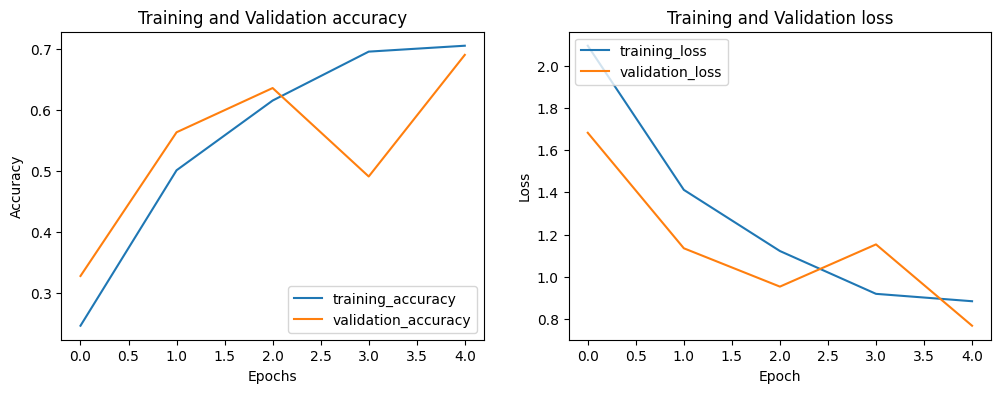

In [ ]:
# plotting accuracy and loss graphs 
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(mod_leaves.history['accuracy'], label= 'training_accuracy')
plt.plot(mod_leaves.history['val_accuracy'], label='validation_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(mod_leaves.history['loss'], label='training_loss')
plt.plot(mod_leaves.history['val_loss'], label = 'validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation loss')

In [ ]:
#save the model with the neame "model_classification"
model_leaves.save("model_classification")

#create a zip archive of the saved model
!zip -r -q /content/model_classification.zip /content/model_classification

In [ ]:
# load a saved model
!unzip -q /content/model_classification.zip -d /
model_leaves = tf.keras.models.load_model("./model_classification")

In [ ]:
#train the model for 15 epochs 
mod_leaves = model_leaves.fit_generator(generator = train_generator,validation_data = valid_generator,epochs=15, callbacks=[checkpoint,earlystopping])

<ipython-input-17-1acbe2686a26>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  mod_leaves = model_leaves.fit_generator(generator = train_generator,validation_data = valid_generator,epochs=15, callbacks=[checkpoint,earlystopping])


Epoch 1/15
68/68 [==============================] - ETA: 0s - loss: 0.8296 - accuracy: 0.7226 
Epoch 1: saving model to weights_epoch_01.h5
68/68 [==============================] - 762s 11s/step - loss: 0.8296 - accuracy: 0.7226 - val_loss: 0.7805 - val_accuracy: 0.6727
Epoch 2/15
68/68 [==============================] - ETA: 0s - loss: 0.7556 - accuracy: 0.7443
Epoch 2: saving model to weights_epoch_02.h5
68/68 [==============================] - 681s 10s/step - loss: 0.7556 - accuracy: 0.7443 - val_loss: 0.7075 - val_accuracy: 0.6909
Epoch 3/15
68/68 [==============================] - ETA: 0s - loss: 0.6736 - accuracy: 0.7702 
Epoch 3: saving model to weights_epoch_03.h5
68/68 [==============================] - 706s 10s/step - loss: 0.6736 - accuracy: 0.7702 - val_loss: 0.6186 - val_accuracy: 0.7091
Epoch 4/15
68/68 [==============================] - ETA: 0s - loss: 0.6525 - accuracy: 0.7702
Epoch 4: saving model to weights_epoch_04.h5
68/68 [==============================] - 690s 10s

In [ ]:
import matplotlib.pyplot as plt 

Text(0.5, 1.0, 'Training and Validation loss')

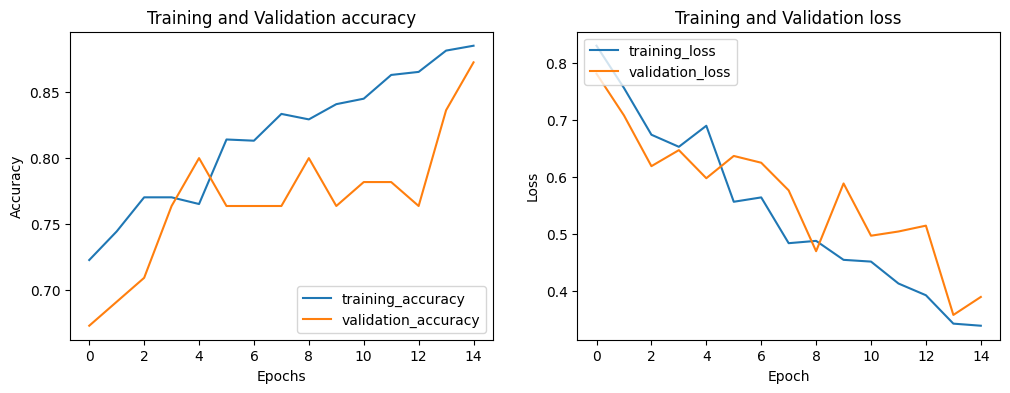

In [ ]:
# plotting accuracy and loss graphs 
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(mod_leaves.history['accuracy'], label= 'training_accuracy')
plt.plot(mod_leaves.history['val_accuracy'], label='validation_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(mod_leaves.history['loss'], label='training_loss')
plt.plot(mod_leaves.history['val_loss'], label = 'validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation loss')

In [ ]:
#model.evaluate on the test folder 
model_leaves.evaluate(test_generator) 

2/2 [==============================] - 18s 8s/step - loss: 0.2710 - accuracy: 0.9091


[0.27104225754737854, 0.9090909361839294]

In [ ]:
#model.predict 
predictions = model_leaves.predict_generator(test_generator)

<ipython-input-21-dc15218a2af3>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_leaves.predict_generator(test_generator)


In [ ]:
import numpy as np 

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
predicted_classes

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  5,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  4,  5,  6,  6,  0,  6,
        5,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  7,  9,  9,  9,  9, 10,
       10, 10, 10, 10])

In [ ]:
true_classes=test_generator.classes

In [ ]:
true_classes

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10], dtype=int32)

In [ ]:
test_generator.class_indices

{'Alstonia Scholaris healthy (P2b)': 0,
 'Arjun healthy (P1b)': 1,
 'Basil healthy (P8)': 2,
 'Chinar healthy (P11a)': 3,
 'Gauva healthy (P3a)': 4,
 'Jamun healthy (P5a)': 5,
 'Jatropha healthy (P6a)': 6,
 'Lemon healthy (P10a)': 7,
 'Mango healthy (P0a)': 8,
 'Pomegranate healthy (P9a)': 9,
 'Pongamia Pinnata healthy (P7a)': 10}

In [ ]:
class_labels = list(test_generator.class_indices.keys())

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#precision,recall and f1-score metrics
report = classification_report(true_classes, predicted_classes,target_names=class_labels)
print(report)

                                  precision    recall  f1-score   support

Alstonia Scholaris healthy (P2b)       0.83      1.00      0.91         5
             Arjun healthy (P1b)       1.00      1.00      1.00         5
              Basil healthy (P8)       1.00      1.00      1.00         5
           Chinar healthy (P11a)       1.00      0.80      0.89         5
             Gauva healthy (P3a)       0.83      1.00      0.91         5
             Jamun healthy (P5a)       0.67      0.80      0.73         5
          Jatropha healthy (P6a)       1.00      0.60      0.75         5
            Lemon healthy (P10a)       0.83      1.00      0.91         5
             Mango healthy (P0a)       1.00      1.00      1.00         5
       Pomegranate healthy (P9a)       1.00      0.80      0.89         5
  Pongamia Pinnata healthy (P7a)       1.00      1.00      1.00         5

                        accuracy                           0.91        55
                       macro avg    

In [ ]:
true_classes.shape

(55,)

In [ ]:
predicted_classes.shape

(55,)

In [ ]:
import seaborn as sns

Text(50.722222222222214, 0.5, 'True Label')

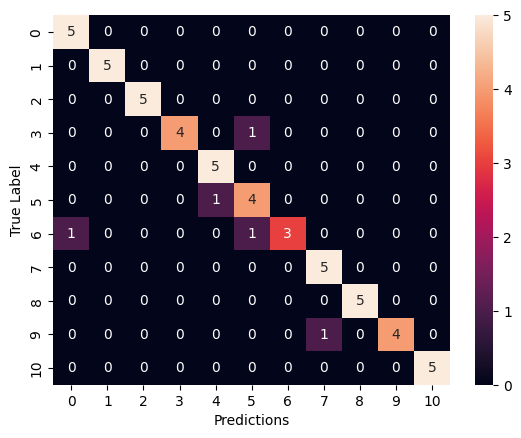

In [ ]:
#confusion matrix plot using heatmap
hm = sns.heatmap(confusion_matrix(true_classes,predicted_classes), annot=True)
hm.set_xlabel('Predictions')
hm.set_ylabel('True Label')